# Spherical Mean Technique

The recently proposed Spherical Mean Technique (SMT) model *(Kaden et al. 2015)* is a spherical convolution-based technique, which instead of a model to multi-shell DWIs, fits the *spherical mean* of the model to the *spherical mean* of the signal per shell. 

SMT observes that if the FOD is a probability density (i.e. integrated to unity) then spherical mean of the signal and the convolution kernel must be the same

\begin{equation}
\int_{\mathbb{S}^2}E_b(\textbf{g})d\textbf{g}=\int_{\mathbb{S}^2}(\operatorname{FOD}\,*_{\mathbb{S}^2}\,K)_b(\textbf{g})d\textbf{g}=\int_{\mathbb{S}^2}K_b(\textbf{g})d\textbf{g}=\epsilon_K(b,\lambda_\perp,\lambda_\parallel).
\end{equation}

The estimation of the multi-compartment kernel using SMT enables the characterization of per-axon micro-environments, as the effects of axon dispersion and crossings are only contained in the FOD.

Advantages:
- Insensitive to axon dispersion and crossings.

Limitations:
- Only accounts for average of tissue properties in crossing configurations, which potentially each have different properties.

# Using Dmipy to set up the SMT Model

To set up the SMT model we start by calling the regular zeppelin model.

In [1]:
from dmipy.signal_models import gaussian_models
zeppelin = gaussian_models.G2Zeppelin()

To initialize a spherical mean model, instead of calling the MultiCompartmentModel, we call MultiCompartmentSphericalMeanModel.

In [2]:
from dmipy.core import modeling_framework
smt_mod = modeling_framework.MultiCompartmentSphericalMeanModel(
    models=[zeppelin])

Notice how the zeppelin's spherical mean representation has no orientation parameter 'mu'.

In [3]:
smt_mod.parameter_names

['G2Zeppelin_1_lambda_perp', 'G2Zeppelin_1_lambda_par']

The only constraint on the Zeppelin model is that $\lambda_\parallel\geq\lambda_\perp$. We can impose this parameter constraint using the model.set_fractional_parameter() function.

In [4]:
smt_mod.set_fractional_parameter('G2Zeppelin_1_lambda_perp', 'G2Zeppelin_1_lambda_par')
smt_mod.parameter_names

['G2Zeppelin_1_lambda_perp_fraction', 'G2Zeppelin_1_lambda_par']

The lambda_perp parameter has now been replaced with lambda_perp_fraction.  
In essence, what this function did is replace the original parameter with a different optimization parameter that operates as a fraction $f$ of $\lambda_{\parallel}$, such that $\lambda_{\perp}=f \times \lambda_{\parallel}$, where $1\geq f \geq 0$. Internally, the $\lambda_{\perp}$ parameter will now always respect the relative "smaller than" constraint to $\lambda_{\parallel}$, and the true value of $\lambda_{\perp}$ can be recovered after fitting the model.

Visualize the model, notice that it's just single model:

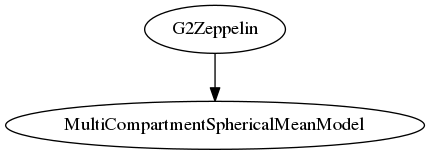

In [5]:
from IPython.display import Image
smt_mod.visualize_model_setup(view=False, cleanup=False)
Image('Model Setup.png')

## Fitting SMT to Human Connectome Project data

In [5]:
from dmipy.data import saved_data
scheme_hcp, data_hcp = saved_data.wu_minn_hcp_coronal_slice()
sub_image = data_hcp[70:90,: , 70:90]

This data slice originates from Subject 100307 of the Human Connectome Project, WU-Minn Consortium (Principal Investigators: David Van Essen and Kamil Ugurbil; 1U54MH091657) funded by the 16 NIH Institutes and Centers that support the NIH Blueprint for Neuroscience Research; and by the McDonnell Center for Systems Neuroscience at Washington University.


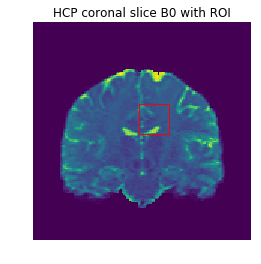

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

fig, ax = plt.subplots(1)
ax.imshow(data_hcp[:, 0, :, 0].T, origin=True)
rect = patches.Rectangle((70,70),20,20,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
ax.set_axis_off()
ax.set_title('HCP coronal slice B0 with ROI');

In [7]:
# Fitting SMT is very fast, half the time is actually spent estimating the spherical mean of the data.
smt_fit_hcp = smt_mod.fit(scheme_hcp, data_hcp, Ns=30, mask=data_hcp[..., 0]>0, use_parallel_processing=False)

Setup brute2fine optimizer in 1.50449085236 seconds
Fitting of 8181 voxels complete in 22.991079092 seconds.
Average of 0.0028103018081 seconds per voxel.


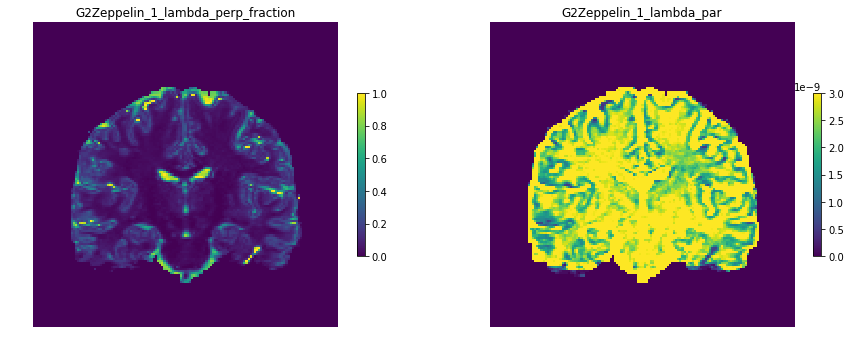

In [8]:
fitted_parameters = smt_fit_hcp.fitted_parameters

fig, axs = plt.subplots(1, len(fitted_parameters), figsize=[15, 15])
axs = axs.ravel()

for i, (name, values) in enumerate(fitted_parameters.items()):
    cf = axs[i].imshow(values.squeeze().T, origin=True)
    axs[i].set_title(name)
    axs[i].set_axis_off()
    fig.colorbar(cf, ax=axs[i], shrink=0.2)

## Estimating Parametric FODs using SMT kernel

Dmipy allows for the estimation of parametric Fiber Orientation Distributions (FODs) using the fitted spherical mean model parameters as a convolution kernel. At this time, it is possible to choose either 'watson' or 'bingham' distributions with any number of compartments.

### Watson FOD estimation
First we fit SMT on a patch where we want to estimate FODs.

In [9]:
smt_fit_patch = smt_mod.fit(scheme_hcp, sub_image, Ns=30)

Using parallel processing with 8 workers.
Setup brute2fine optimizer in 0.0670688152313 seconds
Fitting of 400 voxels complete in 1.86997413635 seconds.
Average of 0.00467493534088 seconds per voxel.


Then we call the fitted SMT model to return a multi-compartment model that is designed to fit $N$ parametric FODs to the data. Note that the returned model is no different from a self-designed regular MultiCompartmentModel - it only differs in that as the kernel properties are fixed to the estimated SMT parameters.

In [10]:
parametric_fod_model= smt_fit_patch.return_parametric_fod_model(
    distribution='watson', Ncompartments=1)

Notice that the FOD optimizer has the same design as a regular MultiCompartmentModel, and all the same solvers and options are available for FOD estimation. In this way, it is possible to have completely different approaches to estimating the kernel using a spherical mean model, and estimating the subsequent parametric FODs.

In [11]:
smt_fod_fit = parametric_fod_model.fit(scheme_hcp, sub_image)

Using parallel processing with 8 workers.
Cannot estimate signal grid with voxel-dependent x0_vector.
Setup brute2fine optimizer in 0.000311851501465 seconds
Fitting of 400 voxels complete in 27.5659279823 seconds.
Average of 0.0689148199558 seconds per voxel.


Fitting an FOD optimizer returns a FittedMultiCompartmentModel, where now all the same functions are available. We will show the estimated FODs in the next example.

### Watson FOD visualization

Here we use the same Dipy procedure as in the previous examples to visualize the FODs.

In [12]:
from dipy.data import get_sphere
from dipy.viz.actor import slicer
sphere = get_sphere(name='symmetric724').subdivide()
fods = smt_fod_fit.fod(sphere.vertices, visual_odi_lower_bound=0.1)

In [13]:
import numpy as np
affine = np.eye(4)
affine[0,3] = -10
affine[1,3] = -10

# lambda_perp = lambda_perp_fraction * lambda_par
volume_res =  (smt_fod_fit.fitted_parameters['SD1WatsonDistributed_1_G2Zeppelin_1_lambda_perp_fraction'] *
               smt_fod_fit.fitted_parameters['SD1WatsonDistributed_1_G2Zeppelin_1_lambda_par'])

volume_im = slicer(volume_res[:, 0, :, None], interpolation='nearest', affine=affine, opacity=0.7)

In [14]:
from dipy.viz import fvtk
ren = fvtk.ren()
fod_spheres = fvtk.sphere_funcs(fods, sphere, scale=1., norm=False)
fod_spheres.RotateX(90)
fod_spheres.RotateZ(180)
fod_spheres.RotateY(180)
fvtk.add(ren, fod_spheres)
fvtk.add(ren, volume_im)
fvtk.record(ren=ren, size=[700, 700])

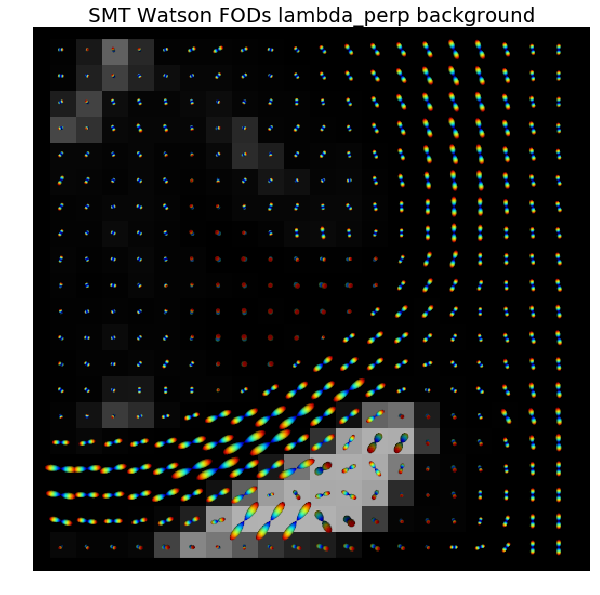

In [ ]:
import matplotlib.image as mpimg
img = mpimg.imread('dipy.png')

plt.figure(figsize=[10, 10])
plt.imshow(img[100:-97, 100:-85])
plt.title('SMT Watson FODs lambda_perp background', fontsize=20)
plt.axis('off');

## Estimating Error Metrics: MSE and $R^2$

It is also possible to calculate the Mean Squared Error (MSE) and the $R^2$ coefficient of determination.  
In MSE, the lower the better, while $R^2$ ranges between 0 and 1, with 1 being a perfect model fit.

In [ ]:
mse = smt_fit_hcp.mean_squared_error(data_hcp)
R2 = smt_fit_hcp.R2_coefficient_of_determination(data_hcp)

fig, axs = plt.subplots(1, 2, figsize=[15, 15])
cf = axs[0].imshow(mse.squeeze().T, origin=True, vmax=1e-3, cmap='Greys_r')
fig.colorbar(cf, ax=axs[0], shrink=0.33)
axs[0].set_title('Mean Squared Error', fontsize=20)
axs[0].set_axis_off()
cf = axs[1].imshow(R2.squeeze().T, origin=True, vmin=.98, cmap='Greys_r')
fig.colorbar(cf, ax=axs[1], shrink=0.33)
axs[1].set_title('R2 - Coefficient of Determination', fontsize=20)
axs[1].set_axis_off();

The MSE shows that the fitting error is overall very low, with higher errors in the CSF and the skull. The $R^2$ agree with the MSE results, having values very close to 1 overall, with lower values in the CSF and skull.

## References
- Kaden, Enrico, et al. "Multi-compartment microscopic diffusion imaging." NeuroImage 139 (2016): 346-359.